# Proyecto Final: Modelos de Hielo

Luis Alemán
\\ Jorge Ramírez

Las siguientes funciones son para implementar el método de los tres colores.

In [1]:
using PyPlot

INFO: Loading help data...


In [2]:
using Interact

La función conf_i genera una configuración inicial que cumple con las reglas del hielo, es decir, no hay colores repetidos a primeros vecinos. Como nuestro algoritmo es ergódico, desde ésta configuración "cíclica" se puede llegar a cualquier otra configuración que cumpla con las reglas del hielo.

In [2]:
function conf_i(n::Int,m::Int)
    out=zeros(n,n)
    out[1,1]=rand(0:2)
    for i in 1:n-1
        for j in 1:n-1
            out[i,j+1]=mod(out[i,j]+1,3)
        end
        out[i+1,:]=mod(out[i,:]+1,3)
    end
    
    #cuando n es 1 mod 3, hay problemas con las reglas de hielo
    if mod(n,3)==1
        out[:,n]=mod(out[:,1]+1,3)
        out[n,:]=mod(out[1,:]+1,3)
        out[n,n]=mod(out[1,1]+2,3)
    end
    out
end

conf_i (generic function with 1 method)

In [3]:
function Single_cluster(arreglo::Array{Float64,2})
    L2=length(arreglo[1,:])
    L1=length(arreglo[:,1])
    red_bool=trues(L1,L2)
    #Se escoge un cuadrado al azar entre toda la red, y su número es escogido como 'colorA'
    i=rand(1:L1)
    j=rand(1:L2)
    colorA=arreglo[i,j]
    #Se escoge al azar un 'colorB' entre los restantes
    colorB=mod(rand(colorA+1:colorA+2),3)
    index_i=[i]
    index_j=[j]
    #Cambio el color de la celda inicial
    arreglo[i,j]=colorB
    red_bool[i,j]=false
    test=false
    t_limit=L1*2
    t=1
    while t<t_limit
        new_index_i=Int[]
        new_index_j=Int[]
        for n=1:length(index_i)
            for ii=0:1
                inew=mod1(index_i[n]+ii*2-1,L1)
                jnew=mod1(index_j[n]+ii*2-1,L2)
                if arreglo[inew,index_j[n]]==colorA && red_bool[inew,index_j[n]]==true
                    push!(new_index_i,inew)
                    push!(new_index_j,index_j[n])
                    red_bool[inew,index_j[n]]=false
                    arreglo[inew,index_j[n]]=colorB
                    test=true
                end
                if arreglo[inew,index_j[n]]==colorB && red_bool[inew,index_j[n]]==true
                    push!(new_index_i,inew)
                    push!(new_index_j,index_j[n])
                    red_bool[inew,index_j[n]]=false
                    arreglo[inew,index_j[n]]=colorA
                    test=true
                end
                if arreglo[index_i[n],jnew]==colorA && red_bool[index_i[n],jnew]==true
                    push!(new_index_i,index_i[n])
                    push!(new_index_j,jnew)
                    red_bool[index_i[n],jnew]=false
                    arreglo[index_i[n],jnew]=colorB
                    test=true
                end
                if arreglo[index_i[n],jnew]==colorB && red_bool[index_i[n],jnew]==true
                    push!(new_index_i,index_i[n])
                    push!(new_index_j,jnew)
                    red_bool[index_i[n],jnew]=false
                    arreglo[index_i[n],jnew]=colorA
                    test=true
                end
            end
        end
        index_i=deepcopy(new_index_i)
        index_j=deepcopy(new_index_j)
        if test==false
            #println("there are no more squares to add")
            t=t_limit
        end
        test=false
    end
    return arreglo
end

Single_cluster (generic function with 1 method)

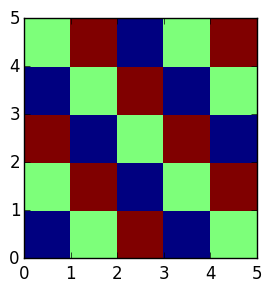

PyObject <matplotlib.collections.QuadMesh object at 0x3126eb2d0>

In [5]:
hey=conf_i(5,5)
fig=figure(figsize=[3,3])
pcolormesh(hey)

In [4]:
function SingleCluster(arreglo::Array{Float64,2},red_bool,i,j,colorA, colorB)
    L2=length(arreglo[1,:])
    L1=length(arreglo[:,1])
    #red_bool=trues(L1,L2)
    arreglo_old=deepcopy(arreglo)
    if arreglo[i,j]==colorA
        arreglo[i,j]=colorB
    else
        arreglo[i,j]=colorA
    end
    index_i=[i]
    index_j=[j]
    red_bool[i,j]=false
    test=false
    t_limit=max(L1,L2)
    t=1
    while t<t_limit
        new_index_i=Int[]
        new_index_j=Int[]
        for n=1:length(index_i)
            for ii=0:1
                inew=mod1(index_i[n]+ii*2-1,L1)
                jnew=mod1(index_j[n]+ii*2-1,L2)
                if arreglo[inew,index_j[n]]==colorA && red_bool[inew,index_j[n]]==true
                    push!(new_index_i,inew)
                    push!(new_index_j,index_j[n])
                    red_bool[inew,index_j[n]]=false
                    arreglo[inew,index_j[n]]=colorB
                    test=true
                end
                if arreglo[inew,index_j[n]]==colorB && red_bool[inew,index_j[n]]==true
                    push!(new_index_i,inew)
                    push!(new_index_j,index_j[n])
                    red_bool[inew,index_j[n]]=false
                    arreglo[inew,index_j[n]]=colorA
                    test=true
                end
                if arreglo[index_i[n],jnew]==colorA && red_bool[index_i[n],jnew]==true
                    push!(new_index_i,index_i[n])
                    push!(new_index_j,jnew)
                    red_bool[index_i[n],jnew]=false
                    arreglo[index_i[n],jnew]=colorB
                    test=true
                end
                if arreglo[index_i[n],jnew]==colorB && red_bool[index_i[n],jnew]==true
                    push!(new_index_i,index_i[n])
                    push!(new_index_j,jnew)
                    red_bool[index_i[n],jnew]=false
                    arreglo[index_i[n],jnew]=colorA
                    test=true
                end
            end
        end
        index_i=deepcopy(new_index_i)
        index_j=deepcopy(new_index_j)
        if test==false
            t=t_limit
        end
        test=false
    end
    #Se escoge con 50% si se cambian o no los colores de este nuevo cluster 
    if rand()<0.5
        #println(":C")
        return arreglo_old,red_bool
    else
        return arreglo,red_bool
    end
end

SingleCluster (generic function with 1 method)

In [5]:
function Update!(red_bool,red_bool_dummy)
    L2=length(red_bool[1,:])
    L1=length(red_bool[:,1])
    for i in 1:L1
        for j in 1:L2
            if red_bool_dummy[i,j]==false
                red_bool[i,j]=false
            end
        end
    end
    #return red_bool
end

Update! (generic function with 1 method)

In [6]:
function MultiCluster(arreglo)
    L2=length(arreglo[1,:])
    L1=length(arreglo[:,1])
    red_bool=trues(L1,L2)
    #hey=[]
    #Se escoge al azar dos colores
    colorA=rand(0:2)
    colorB=mod(rand(colorA+1:colorA+2),3)
    for i in 1:L1
        for j in 1:L2
            if red_bool[i,j]==true
                if arreglo[i,j]==colorA || arreglo[i,j]==colorB
                    arreglo,red_bool_dummy=SingleCluster(arreglo,red_bool,i,j,colorA,colorB)
                    Update!(red_bool,red_bool_dummy)
                end
            end
        end
    end
    return arreglo
end

MultiCluster (generic function with 1 method)

hey = [2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0
 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0
 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0
 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0
 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0
 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0
 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0
 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0
 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0
 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0
 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0
 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0 0.0 1.0 2.0
 2.0 0.0 1.0 2.0 0.0 1

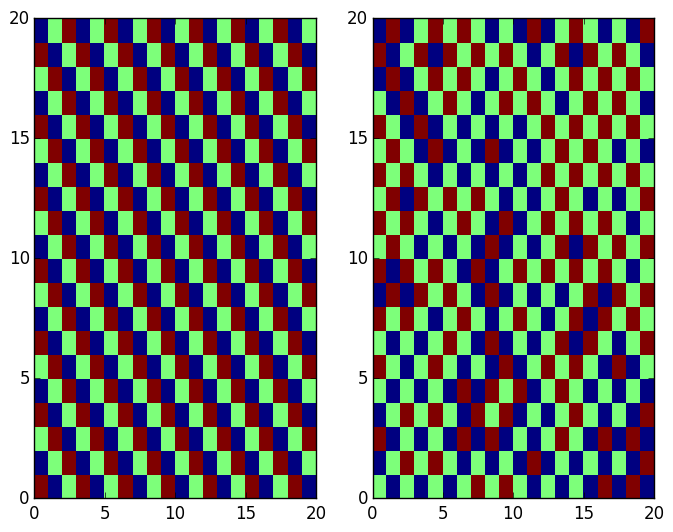

PyObject <matplotlib.collections.QuadMesh object at 0x307533550>

In [9]:
hey_old=conf_i(20,20)
hey=copy(hey_old)
@show hey
for t in 1:1000
    hey_new=MultiCluster(hey_old)
    hey_new,hey_old=hey_old,hey_new
end
figure(figsize=[8,6])
subplot(1,2,1)
#figure(figsize=[3,3])
pcolormesh(hey)

subplot(1,2,2)
pcolormesh(hey_old)

#Energías

Existen muchos modelos energéticos para el arreglo de los Hidrógenos en los Oxígenos. Trabajaremos con el modelo $F$ que favorece los arreglos simétricos. Para el modelo de 3 colores, esto se traduce en parejas de segundos vecinos (diagonales) del mismo color. El hamiltoniano se transforma entonces:
$$H=-\epsilon \sum \limits_{[i,j]}(\delta_{c_ic_j} - \frac{1}{2})=N\epsilon - \epsilon \sum \limits_{[i,j]}\delta_{c_ic_j}$$

El algoritmo entonces para crear clusters que favorezcan parejas de segundos vecinos del mismo color dependiente de la temperatura será:
1. Escogemos un cuadro de toda la red como semilla de nuestro cluster. Este cuadro tiene color A.
2. Escogemos un segundo color de las otras dos posibilidades, lo llamamos color B.
3. Empezando de nuestra semilla, formamos un cluster de cuadros añadiendo todos los primeros vecinos que tengan color A o color B, pero además ahora incluiremos con probablidad $P_{add}(T)$ a los segundos vecinos del cuadro $i$ que ya está en el cluster con la condición que tengan el mismo color que $i$.
4. Los colores A y B de todos los cuadros del cluster son intercambiados.

$$P_{add}=1-e^{-\beta \epsilon}$$

In [7]:
function segundos_vecinos(arreglo::Array{Float64,2},i,j)
    L1=length(arreglo[:,1])
    L2=length(arreglo[1,:])
    arreglo[mod1(i-1,L1),mod1(j-1,L2)],arreglo[mod1(i-1,L1),mod1(j+1,L2)],arreglo[mod1(i+1,L1),mod1(j-1,L2)],arreglo[mod1(i+1,L1),mod1(j+1,L2)]
end

segundos_vecinos (generic function with 1 method)

In [8]:
function indices_segundos(ij,i,j,L1,L2)
    if ij==1
        return mod1(i-1,L1),mod1(j-1,L2)
        elseif ij==2
        return mod1(i-1,L1),mod1(j+1,L2)
        elseif ij==3
        return mod1(i+1,L1),mod1(j-1,L2)
        elseif ij==4
        return mod1(i+1,L1),mod1(j+1,L2)
    end
end

indices_segundos (generic function with 1 method)

In [9]:
function contador_segundos(arreglo::Array{Float64,2})
    L1=length(arreglo[:,1])
    L2=length(arreglo[1,:])
    contador=0
    for i in 1:L1
        for j in 1:L2
            for ij in 1:4
                if segundos_vecinos(arreglo,i,j)[ij]==arreglo[i,j]
                    contador+=1
                end
            end
        end
    end
    contador/2
end

contador_segundos (generic function with 1 method)

In [10]:
function Single_cluster_E(β,arreglo::Array{Float64,2},ϵ=1.0)
    L2=length(arreglo[1,:])
    L1=length(arreglo[:,1])
    red_bool=trues(L1,L2)
    P_add=1-e^(-β*ϵ)
    #Se escoge un cuadrado al azar entre toda la red, y su número es escogido como 'colorA'
    i=rand(1:L1)
    j=rand(1:L2)
    colorA=arreglo[i,j]
    #Se escoge al azar un 'colorB' entre los restantes
    colorB=mod(rand(colorA+1:colorA+2),3)
    index_i=[i]
    index_j=[j]
    colorC=3-(colorA+colorB)
    #Cambio el color de la celda inicial
    arreglo[i,j]=colorB
    red_bool[i,j]=false
    test=false
    t_limit=L1*2
    t=1
    while t<t_limit
        new_index_i=Int[]
        new_index_j=Int[]
        for n=1:length(index_i)
            for ii=0:1
                inew=mod1(index_i[n]+ii*2-1,L1)
                jnew=mod1(index_j[n]+ii*2-1,L2)
                if arreglo[inew,index_j[n]]==colorA && red_bool[inew,index_j[n]]==true
                    push!(new_index_i,inew)
                    push!(new_index_j,index_j[n])
                    red_bool[inew,index_j[n]]=false
                    arreglo[inew,index_j[n]]=colorB
                    test=true
                end
                if arreglo[inew,index_j[n]]==colorB && red_bool[inew,index_j[n]]==true
                    push!(new_index_i,inew)
                    push!(new_index_j,index_j[n])
                    red_bool[inew,index_j[n]]=false
                    arreglo[inew,index_j[n]]=colorA
                    test=true
                end
                if arreglo[index_i[n],jnew]==colorA && red_bool[index_i[n],jnew]==true
                    push!(new_index_i,index_i[n])
                    push!(new_index_j,jnew)
                    red_bool[index_i[n],jnew]=false
                    arreglo[index_i[n],jnew]=colorB
                    test=true
                end
                if arreglo[index_i[n],jnew]==colorB && red_bool[index_i[n],jnew]==true
                    push!(new_index_i,index_i[n])
                    push!(new_index_j,jnew)
                    red_bool[index_i[n],jnew]=false
                    arreglo[index_i[n],jnew]=colorA
                    test=true
                end
            end
            #Segundos vecinos
            segundo=segundos_vecinos(arreglo,index_i[n],index_j[n])
            for ij in 1:4
                ii_new=indices_segundos(ij,index_i[n],index_j[n],L1,L2)[1]
                jj_new=indices_segundos(ij,index_i[n],index_j[n],L1,L2)[2]
                if segundo[ij] !=arreglo[index_i[n],index_j[n]] && segundo[ij] !=colorC && red_bool[ii_new,jj_new]==true
                    if rand()<P_add
                        push!(new_index_i,ii_new)
                        push!(new_index_j,jj_new)
                        red_bool[ii_new,jj_new]=false
                        if arreglo[index_i[n],index_j[n]]==colorA
                                arreglo[ii_new,jj_new]=colorA
                        else
                                arreglo[ii_new,jj_new]=colorB
                        end
                        test=true
                    end
                end
            end
        end
        index_i=deepcopy(new_index_i)
        index_j=deepcopy(new_index_j)
        if test==false
            #println("there are no more squares to add")
            t=t_limit
        end
        test=false
    end
    return arreglo
end

Single_cluster_E (generic function with 2 methods)

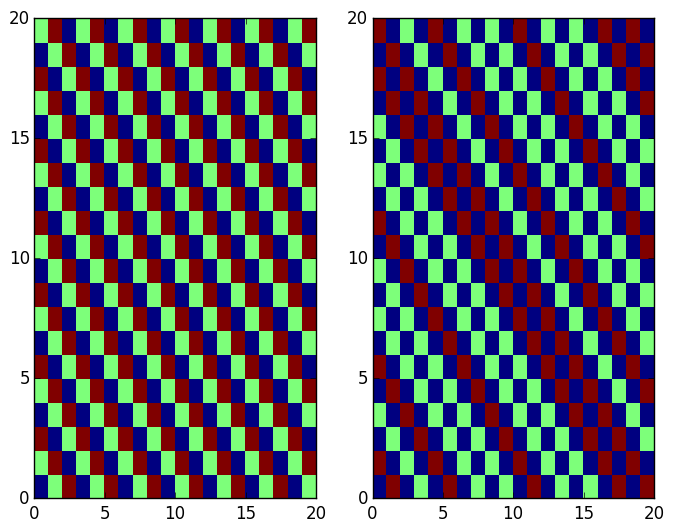

PyObject <matplotlib.collections.QuadMesh object at 0x7f262ee45ad0>

In [43]:
inicial_s=conf_i(20,20)
old=copy(inicial_s)
for t in 1:10
    new=Single_cluster_E(1000.0,old)
    new,old=old,new
end
figure(figsize=[8,6])
subplot(1,2,1)
#figure(figsize=[3,3])
pcolormesh(inicial_s)

subplot(1,2,2)
pcolormesh(old)

In [21]:
contador_segundos(inicial),contador_segundos(old)

(400.0,702.0)

In [36]:
old=conf_i(20,20)
betas=[i*0.2 for i in 0:20]
out=zeros(length(betas))
@time for i in 1:length(betas)
    for t in 1:1000
        new=Single_cluster_E(betas[i],old)
        old,new=new,old
    end
    out[i]=contador_segundos(old)
end

elapsed time: 98.314305672 seconds (17522185952 bytes allocated, 28.17% gc time)


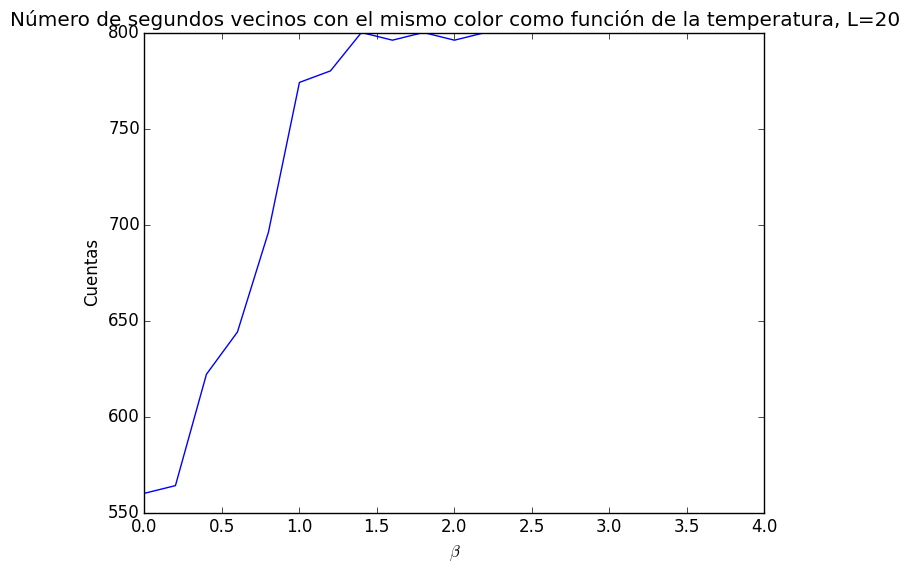

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc4900c1e50>

In [39]:
title("Número de segundos vecinos con el mismo color como función de la temperatura, L=20")
xlabel(L"$\beta$")
ylabel("Cuentas")
plot(betas,out)

###A medida que la temperatura baja, vemos que es más fácil aceptar los cambios y el número de segundos vecinos con el mismo color tiende a su máximo de 2N

In [22]:
old=conf_i(30,30)
inicial=copy(old)
for t in 1:1000
    new=Single_cluster_E(0.1,old)
    old,new=new,old
end

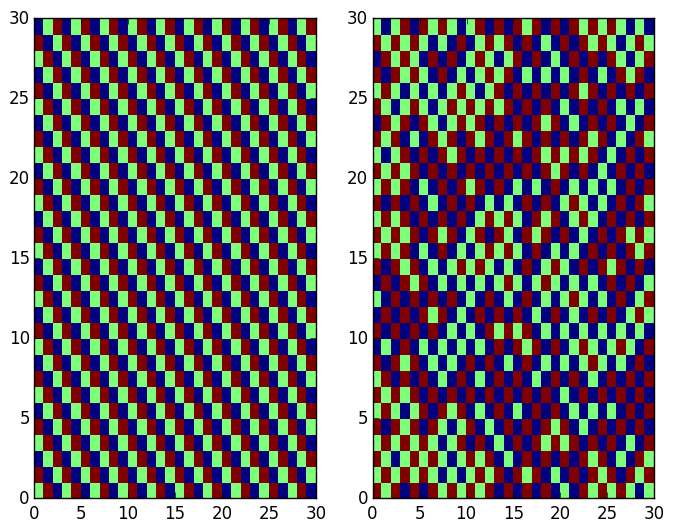

PyObject <matplotlib.collections.QuadMesh object at 0x7f262fba1a10>

In [23]:
figure(figsize=[8,6])
subplot(1,2,1)
#figure(figsize=[3,3])
pcolormesh(inicial)

subplot(1,2,2)
pcolormesh(old)

#A partir de aquí las cosas funcionan tan bien, multicluster.

In [44]:
function conf_random(L1::Int,L2::Int,pasos=100)
    old=conf_i(L1,L2)
    for t in 1:pasos
        new=MultiCluster(old)
        new,old=old,new
    end
    old
end

conf_random (generic function with 2 methods)

In [24]:
function SingleCluster_E(β,arreglo::Array{Float64,2},red_bool,i,j,colorA,colorB,colorC,ϵ=1.0)
    L2=length(arreglo[1,:])
    L1=length(arreglo[:,1])
    P_add=1-e^(-β*ϵ)
    arreglo_old=copy(arreglo)
    if arreglo[i,j]==colorA
        arreglo[i,j]=colorB
    else
        arreglo[i,j]=colorA
    end
    index_i=[i]
    index_j=[j]
    red_bool[i,j]=false
    test=false
    t_limit=max(L1,L2)
    t=1
    while t<t_limit
        new_index_i=Int[]
        new_index_j=Int[]
        for n=1:length(index_i)
            for ii=0:1
                inew=mod1(index_i[n]+ii*2-1,L1)
                jnew=mod1(index_j[n]+ii*2-1,L2)
                if arreglo[inew,index_j[n]]==colorA && red_bool[inew,index_j[n]]==true
                    push!(new_index_i,inew)
                    push!(new_index_j,index_j[n])
                    red_bool[inew,index_j[n]]=false
                    arreglo[inew,index_j[n]]=colorB
                    test=true
                end
                if arreglo[inew,index_j[n]]==colorB && red_bool[inew,index_j[n]]==true
                    push!(new_index_i,inew)
                    push!(new_index_j,index_j[n])
                    red_bool[inew,index_j[n]]=false
                    arreglo[inew,index_j[n]]=colorA
                    test=true
                end
                if arreglo[index_i[n],jnew]==colorA && red_bool[index_i[n],jnew]==true
                    push!(new_index_i,index_i[n])
                    push!(new_index_j,jnew)
                    red_bool[index_i[n],jnew]=false
                    arreglo[index_i[n],jnew]=colorB
                    test=true
                end
                if arreglo[index_i[n],jnew]==colorB && red_bool[index_i[n],jnew]==true
                    push!(new_index_i,index_i[n])
                    push!(new_index_j,jnew)
                    red_bool[index_i[n],jnew]=false
                    arreglo[index_i[n],jnew]=colorA
                    test=true
                end
            end
            segundo=segundos_vecinos(arreglo,index_i[n],index_j[n])
            for ij in 1:4
                ii_new=indices_segundos(ij,index_i[n],index_j[n],L1,L2)[1]
                jj_new=indices_segundos(ij,index_i[n],index_j[n],L1,L2)[2]
                if segundo[ij] !=arreglo[index_i[n],index_j[n]] && segundo[ij] !=colorC && red_bool[ii_new,jj_new]==true
                    if rand()<P_add
                    #println("aceptó")
                        push!(new_index_i,ii_new)
                        push!(new_index_j,jj_new)
                        red_bool[ii_new,jj_new]=false
                        if arreglo[index_i[n],index_j[n]]==colorA
                                arreglo[ii_new,jj_new]=colorA
                        else
                                arreglo[ii_new,jj_new]=colorB
                        end
                        test=true
                    end
                end
            end
        end
        index_i=deepcopy(new_index_i)
        index_j=deepcopy(new_index_j)
        if test==false
            t=t_limit
        end
        test=false
    end
    if rand()<0.5
        #println(":C")
        return arreglo_old,red_bool
    else
        return arreglo,red_bool
    end
end

SingleCluster_E (generic function with 2 methods)

In [25]:
function MultiCluster_E(β,arreglo,ϵ=1.0)
    L2=length(arreglo[1,:])
    L1=length(arreglo[:,1])
    red_bool=trues(L1,L2)
    #Se escoge al azar dos colores
    colorA=rand(0:2)
    colorB=mod(rand(colorA+1:colorA+2),3)
    colorC=3-(colorA+colorB)
    for i in 1:L1
        for j in 1:L2
            if red_bool[i,j]==true
                if arreglo[i,j]==colorA || arreglo[i,j]==colorB
                    arreglo,red_bool_dummy=SingleCluster_E(β,arreglo,red_bool,i,j,colorA,colorB,colorC)
                    Update!(red_bool,red_bool_dummy)
                end
            end
        end
    end
    return arreglo
end

MultiCluster_E (generic function with 2 methods)

Si se usara como distribución inicial, las diagonales

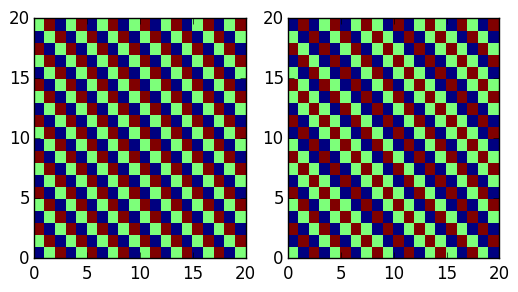

PyObject <matplotlib.collections.QuadMesh object at 0x7f262dd0b890>

In [54]:
inicial=conf_i(20,20)
old=copy(inicial)
for t in 1:2
    new=MultiCluster_E(1000.0,old)
    new,old=old,new
end
figure(figsize=[6,3])
subplot(1,2,1)
#figure(figsize=[3,3])
pcolormesh(inicial)

subplot(1,2,2)
pcolormesh(old)

Hasta converge "endiabladamente" rápido

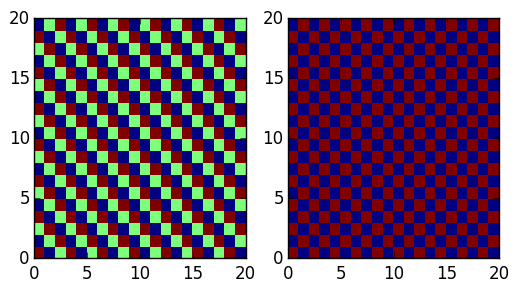

PyObject <matplotlib.collections.QuadMesh object at 0x7f262d350210>

In [60]:
inicial=conf_i(20,20)
old=copy(inicial)
for t in 1:20
    new=MultiCluster_E(1000.0,old)
    new,old=old,new
end
figure(figsize=[6,3])
subplot(1,2,1)
#figure(figsize=[3,3])
pcolormesh(inicial)

subplot(1,2,2)
pcolormesh(old)

###Usando como configuración inicial una configuración procesada por Multicluster sin energía después de 100 pasos:

In [58]:
old=conf_random(50,50);

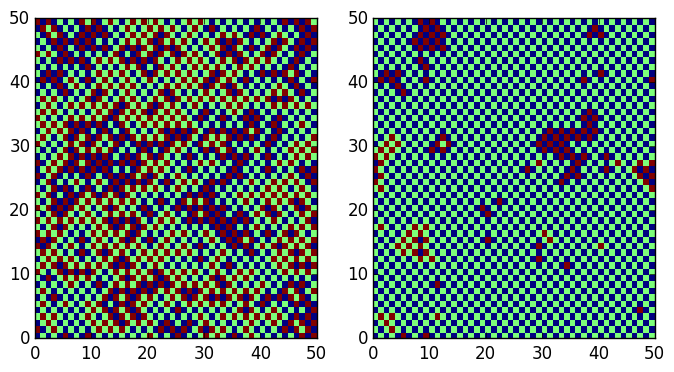

PyObject <matplotlib.collections.QuadMesh object at 0x7f262d666390>

In [59]:
inicial=copy(old)
for t in 1:10
    new=MultiCluster_E(1000.0,old)
    new,old=old,new
end

figure(figsize=[8,4])
subplot(1,2,1)
#figure(figsize=[3,3])
pcolormesh(inicial)

subplot(1,2,2)
pcolormesh(old)

In [91]:
function contadorespromedio_beta(configuracion_inicial::Array{Float64,2},β_max=5.0,t_max=50,paso=0.2)
    betas=[0:paso:β_max]
    maximo=length(betas)
    out=zeros(maximo)
    for i in 1:maximo
        old=copy(configuracion_inicial)
        for t in 1:t_max
            new=MultiCluster_E(betas[i],old)
            out[i]+=contador_segundos(new)
            new,old=old,new
        end
        out[i]=out[i]/t_max
    end
    out
end

contadorespromedio_beta (generic function with 8 methods)

In [92]:
config=conf_random(50,50);

In [93]:
promedios=contadorespromedio_beta(config)

26-element Array{Float64,1}:
 3456.08
 3602.92
 3787.2 
 4016.44
 4307.96
 4576.56
 4732.2 
 4824.4 
 4783.6 
 4810.72
 4876.68
 4876.12
 4797.44
 4856.88
 4848.36
 4892.56
 4858.6 
 4837.4 
 4836.76
 4823.36
 4835.76
 4898.72
 4875.2 
 4852.28
 4707.88
 4858.08

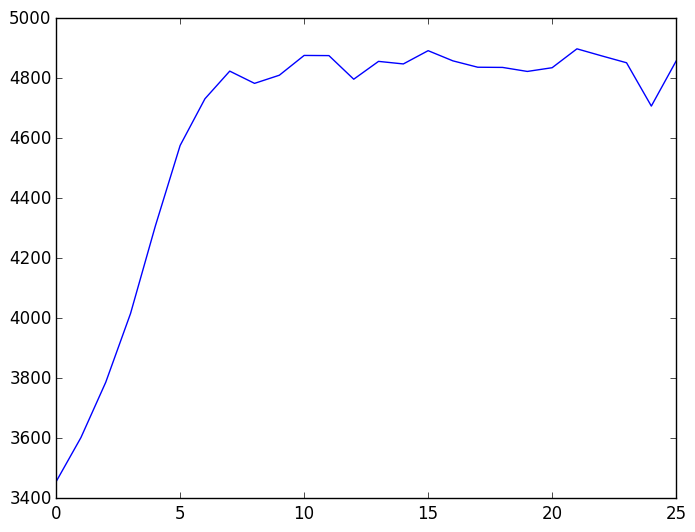

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f262cfee8d0>

In [94]:
plot(promedios)